# 一.项目背景与介绍

Netflix是一种流媒体服务，允许用户在数千台联网设备上观看各种获奖的电视节目、电影、纪录片等。
在190多个国家的电视节目和电影中，Netflix会员可以即时访问大量内容。Netflix拥有广泛的全球内容库，其中包括获奖的Netflix原创作品、故事片、纪录片、电视节目等。Netflix的内容将因地区而异，并且可能会随着时间的推移而变化。用户看得越多，Netflix就越精准地推荐用户喜欢的电视节目和电影，并且无需广告。

数据来源：
* kaggle数据科学社区Netflix Movies and TV Shows7787条数据集。
* TMDB TOP排行上爬虫的5000条数据集。

项目目的：
* 对Netflix的电影/电视节目进行探索性数据分析（EDA），了解当下电影/电视节目市场。
* 搭建一个电影推荐系统，模拟推荐用户喜欢的相似电影，为Netflix之后的推荐方向提供优化策略。

# 二.定义问题

* 1) 不同国家的电视和电影内容分布有何差异？
* 2) 电视和电影内容分布如何随时间而变化？
* 3) Netflix用户群体都有哪些？用户的喜好与哪些因素有关？
* 4) Netflix上主推哪些类型的内容？
* 5) Netflix上内容页面查看次数与评分次数的相关关系？
* 6) 如何在下一阶段规划Netflix的电影/电视节目的上架？
* 7) 如何推荐内容给客户可以提升精准度？


# 三.导入和清洗数据

## 1)导入数据

In [1]:
#导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.graph_objs import Scatter
#设置中文
from matplotlib.font_manager import _rebuild
_rebuild()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pyplot = py.offline.iplot

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=False)

In [3]:
#导入数据
data = open('dataset/netflix_titles.csv')
netflix_data=pd.read_csv(data)
netflix_data.head()

show_id     type                                              title  \
0    s981  TV Show                                       Bling Empire   
1   s1223  TV Show                                    Carmen Sandiego   
2   s1286    Movie                                           Charming   
3   s1356    Movie  Chris Rock Total Blackout: The Tamborine Exten...   
4   s1441  TV Show                                          Cobra Kai   

       director                                               cast  \
0           NaN                                                NaN   
1           NaN  Gina Rodriguez, Finn Wolfhard, Abby Trott, Mic...   
2  Ross Venokur  Wilmer Valderrama, Demi Lovato, Sia, Nia Varda...   
3    Chris Rock                                         Chris Rock   
4           NaN  Ralph Macchio, William Zabka, Xolo Maridue帽a, ...   

                                 country date_added  release_year rating  \
0                                    NaN  15-Jan-21          2021  TV-MA   
1                          United States  15-Jan-21          2021  TV-Y7   
2  Canada, United States, Cayman Islands   8-Jan-21          2021  TV-Y7   
3                                    NaN  12-Jan-21          2021  TV-MA   
4                          United States   1-Jan-21          2021  TV-14   

    duration                           listed_in  \
0   1 Season                          Reality TV   
1  4 Seasons              Kids' TV, TV Thrillers   
2     85 min  Children & Family Movies, Comedies   
3     98 min                     Stand-Up Comedy   
4  3 Seasons    TV Action & Adventure, TV Dramas   

                                         description  
0  Follow LA's wildly wealthy Asian and Asian Ame...  
1  A master thief who uses her skills for good, C...  
2  On the eve of his 21st birthday, an adored pri...  
3  In this extended cut of his 2018 special, Chri...  
4  Decades after the tournament that changed thei...

## 2)理解数据

In [5]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
show_id         7787 non-null object
type            7787 non-null object
title           7787 non-null object
director        5398 non-null object
cast            7069 non-null object
country         7280 non-null object
date_added      7777 non-null object
release_year    7787 non-null int64
rating          7780 non-null object
duration        7787 non-null object
listed_in       7787 non-null object
description     7787 non-null object
dtypes: int64(1), object(11)
memory usage: 730.1+ KB


表中一共7787行数据，包含12个变量，分别为内容id号，类型，电影/电视名，导演，演员，国家，上架日期，发行日期，级别，时长，流派，描述。

In [6]:
netflix_data.describe()

release_year
count   7787.000000
mean    2013.932580
std        8.757395
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2018.000000
max     2021.000000

## 3)数据清洗

### 查看缺失值的分布情况

In [7]:
netflix_data.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [8]:
netflix_data.isnull().sum()/netflix_data.count()

show_id         0.000000
type            0.000000
title           0.000000
director        0.442571
cast            0.101570
country         0.069643
date_added      0.001286
release_year    0.000000
rating          0.000900
duration        0.000000
listed_in       0.000000
description     0.000000
dtype: float64

缺失值为5列，分别为：

* 导演：导演一定程度上可能影响观众对电影/电视的喜爱程度，计划保留此列并用do data代替。
* 演员：演员较大程度上可能影响观众对电影/电视的喜爱程度，仍计划保留此列并用do data代替。
* 国家：国家是一个重量衡量因素，故计划用mode()众数替代。
* 上架日期：缺失比重很小，且影响程度可忽略不计，计划删除。
* 分级：缺失比重很小，且影响程度可忽略不计，计划删除。

### 处理缺失值

In [9]:
# 替代缺失值
netflix_data['country'] = netflix_data['country'].fillna(netflix_data['country'].mode()[0])
netflix_data['cast'].replace(np.nan, 'No Data',inplace  = True)
netflix_data['director'].replace(np.nan, 'No Data',inplace  = True)

# 删除缺失值
netflix_data.dropna(inplace=True)

# 删除重复值
netflix_data.drop_duplicates(inplace= True)

In [10]:
netflix_data.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [11]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7770 entries, 0 to 7786
Data columns (total 12 columns):
show_id         7770 non-null object
type            7770 non-null object
title           7770 non-null object
director        7770 non-null object
cast            7770 non-null object
country         7770 non-null object
date_added      7770 non-null object
release_year    7770 non-null int64
rating          7770 non-null object
duration        7770 non-null object
listed_in       7770 non-null object
description     7770 non-null object
dtypes: int64(1), object(11)
memory usage: 789.1+ KB


### 日期数据格式转换

处理完缺失值后，一共显示7770行数据，但是data_added列的日期格式不规范，需格式化。

In [12]:
netflix_data["date_added"] = pd.to_datetime(netflix_data['date_added'])
netflix_data['month_added']=netflix_data['date_added'].dt.month
netflix_data['month_name_added']=netflix_data['date_added'].dt.month_name()
netflix_data['year_added'] = netflix_data['date_added'].dt.year
netflix_data.head(2)

show_id     type            title director  \
0    s981  TV Show     Bling Empire  No Data   
1   s1223  TV Show  Carmen Sandiego  No Data   

                                                cast        country  \
0                                            No Data  United States   
1  Gina Rodriguez, Finn Wolfhard, Abby Trott, Mic...  United States   

  date_added  release_year rating   duration               listed_in  \
0 2021-01-15          2021  TV-MA   1 Season              Reality TV   
1 2021-01-15          2021  TV-Y7  4 Seasons  Kids' TV, TV Thrillers   

                                         description  month_added  \
0  Follow LA's wildly wealthy Asian and Asian Ame...            1   
1  A master thief who uses her skills for good, C...            1   

  month_name_added  year_added  
0          January        2021  
1          January        2021

# 四.数据可视化（探索性数据分析）

## 1）电影 VS 电视节目

In [13]:
movie_df = netflix_data[netflix_data['type'] == 'Movie']
TVshow_df = netflix_data[netflix_data['type'] == 'TV Show']

### 电影和电视节目的数量分布如何？

In [16]:
type_df=netflix_data['type'].value_counts()
trace=[go.Pie(labels = type_df.index.tolist(), values = type_df.values.tolist(),
              hole=0.5, textfont=dict(size=15, color='white'))]
layout = go.Layout(title='电影和电视节目数量占比分布')
fig=go.Figure(data=trace, layout=layout)
pyplot(fig)

<img src="PlotlyChart/plotly1.png" width="80%">

如环形图可知，Netflix中对电影的投资相对电视节目来说，明显更多；数量上，电影比电视多出一倍。

### 不同国家的电视和电影内容分布有何差异？

根据国家/地区为粒度分析，哪个国家/地区生产的内容最多？

In [17]:
country_df=netflix_data['country'].value_counts()
country_df.describe()

count     681.000000
mean       11.409692
std       124.114467
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      3051.000000
Name: country, dtype: float64

由此可见Netflix中国家的内容分布不均匀，内容分布的最多的国家是3051个，最少的国家是1个，并且TOP前25个国家的内容分布均值仍为最小值1，因此取Top10和Top20的国家内容分布信息来分析比较。

In [18]:
country_Top10 = country_df.head(10)
country_Top20 = country_df.head(20)

In [19]:
trace=[go.Pie(labels = country_Top10.index.tolist(), values = country_Top10.values.tolist(),
              textfont=dict(size=20))]
layout = go.Layout(title='Top 10 国家/地区的电影和电视节目内容的分布')
fig=go.Figure(data=trace, layout=layout)
pyplot(fig)

<img src="PlotlyChart/plotly2.png" width="80%">

很明显，美国几乎占据Netfix上一般的内容分布。

In [20]:
trace_basic = [go.Bar(x=country_Top20.index.tolist(), y=country_Top20.values.tolist(),
                    marker =dict(color = ['red','blue','yellow','green','orange','darkgrey','darkblue','lightpink','darkred','darkgreen']),
                    opacity=0.50)]
layout = go.Layout(height=600, width=1000,title='Top 20 国家/地区的电影和电视节目内容的分布',xaxis = dict(title='国家'),yaxis=dict(title='内容分布数量'))
figure_basic = go.Figure(data=trace_basic,layout = layout)
pyplot(figure_basic)

<img src="PlotlyChart/plotly3.png" width="80%">

Netflix上内容分布最多数量的国家是美国，印度和英国，其他国家在内容分布上差距较大。美国占据主导地位，毕竟Netflix是一家美国公司。虽然英国的电影/电视节目市场是美国的最大竞争者，但仍落后于印度。


### 电视和电影内容分布如何随时间而变化？

In [21]:
date_df=netflix_data['date_added'].value_counts()

In [22]:
date_df.index.min()

Timestamp('2008-01-01 00:00:00')

In [23]:
date_df.index.max()

Timestamp('2021-01-16 00:00:00')

Netfix上电影和电视发行的年份从2008年到2021年之间，分别对电影和电视的发行年份进行分析。

In [24]:
TVshow_year_df = TVshow_df['year_added'].value_counts()
movie_year_df=movie_df['year_added'].value_counts()

In [25]:
M_year_X=np.sort(movie_year_df.index).tolist()
M_year_Y=np.sort(movie_year_df.values).tolist()
T_year_X=np.sort(TVshow_year_df.index).tolist()
T_year_Y=np.sort(TVshow_year_df.values).tolist()
trace1=go.Scatter(x=M_year_X, y=M_year_Y,mode='markers+lines',
                  line=dict(width=2,color='red'),name='Movie')
trace2=go.Scatter(x=T_year_X, y=T_year_Y,mode='markers+lines',
                  line=dict(width=2,color='black'),name='TV Show')
data=[trace1, trace2]
layout = dict(height=500, width=800,title = 'Netflix更新内容时间（年份）', xaxis = dict(title = '年份'), yaxis = dict(title = '数量'))
fig = dict(data=data, layout=layout)
pyplot(fig)

<img src="PlotlyChart/plotly4.png" width="80%">

显然，过去几年Nextflix发展的比较缓慢，2015年开始慢慢好转；从2016年开始发展速度显著增加，至2020年有所增缓解，可能是新冠疫情疾病导致。并且Netflix自2018年起在电影上的投资要远多于电视节目。那么为了促进公司发展，Netfix一般会选择什么时候上架新片？

In [26]:
#取月份相关数据和list
month_df=netflix_data['month_added'].value_counts()
X=np.sort(month_df.index).tolist()
Y=np.sort(month_df.values).tolist()
#取平均值
mean_value=month_df.values.mean()
average=np.tile(mean_value,12)
#折线图
trace=go.Scatter(x=X, y=Y,mode='markers+lines',
                  line=dict(width=4,color='green'),name='TV&Movie')
trace_average=go.Scatter(x=X,y=average,mode='lines', line=dict(width=2,color='red'),name='平均值')
data=[trace,trace_average]
layout=go.Layout(height=500, width=800,title='不同月份上架的电影和电视节目分布',xaxis=dict(title='月份'),yaxis=dict(title='数量'))
fig=go.Figure(data=data,layout=layout)
pyplot(fig)

<img src="PlotlyChart/plotly5.png" width="80%">

Netflix在不同月份中发布的电影/电视节目的内容数量均值接近650，1-8月是淡季，8月之后上片率超过均值，显著增加。在每年年底的10月~12月的旺季上架新片最适合，其中12月最佳，原因可能是12月不仅是国外的每年圣诞节和平安夜集中假期，而且学生假期和上班族的年假接踵而来。 

### 分析电影和电视节目的分级异同

Nextflix上每个电视节目/电影都定义了等级，来帮助成人和孩子做出可观看程度的明确指示。Netflix根据电视节目或电影中内容的影响成程度来确定等级。分级制度如下：
* 2~6岁儿童：G, TV-Y, TV-G
* 7~12岁儿童：PG, TV-Y7, TV-Y7-FV, TV-PG	
* 13~17岁青少年：PG-13, TV-14
* 18岁以上成年人：R, NC-17, TV-MA

另外：NR和UR的分级含义：NR属于未经定级的电影，而UR是针对1968年以前的电影定的级。故在此属于异常值，需删除处理。

那么，等级制是否能帮助圈定电影/电视节目适合的用户群体？

In [27]:
#删除rating等于NR和UR的异常值
netflix_data['rating'].value_counts()
df=netflix_data[netflix_data['rating']!='NR']
rating_data=df[df['rating']!='UR']
rating_data['rating'].value_counts()

TV-MA       2861
TV-14       1928
TV-PG        804
R            665
PG-13        386
TV-Y         279
TV-Y7        270
PG           247
TV-G         194
G             39
TV-Y7-FV       6
NC-17          3
Name: rating, dtype: int64

In [28]:
movie = rating_data[rating_data['type'] == 'Movie']
TVshow = rating_data[rating_data['type'] == 'TV Show']
rating_order =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']

Movie_rating = movie['rating'].value_counts()[rating_order]
Tv_rating = TVshow['rating'].value_counts()[rating_order].fillna(0)

/Users/weiminpang/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:850: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [29]:
#绘制柱状图
def rating_barplot(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(20, 10))
    if h_lim :
        ax.set_ylim(0, h_lim)
    ax.bar(data.index, data,  color="#d0d0d0", width=0.6, edgecolor='black')

    color =  ['green',  'orange',  'red',  'black']
    span_range = [[0, 2], [3,  6], [7, 8], [9, 11]]

    for idx, sub_title in enumerate(['2-6岁儿童', '7-12岁儿童', '13-17岁青少年', '18岁以上成年人']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.1)

    ax.set_title(f'{title}的等级分布', fontsize=20, fontweight='bold', position=(0.5, 1.0+0.03))
    plt.show()

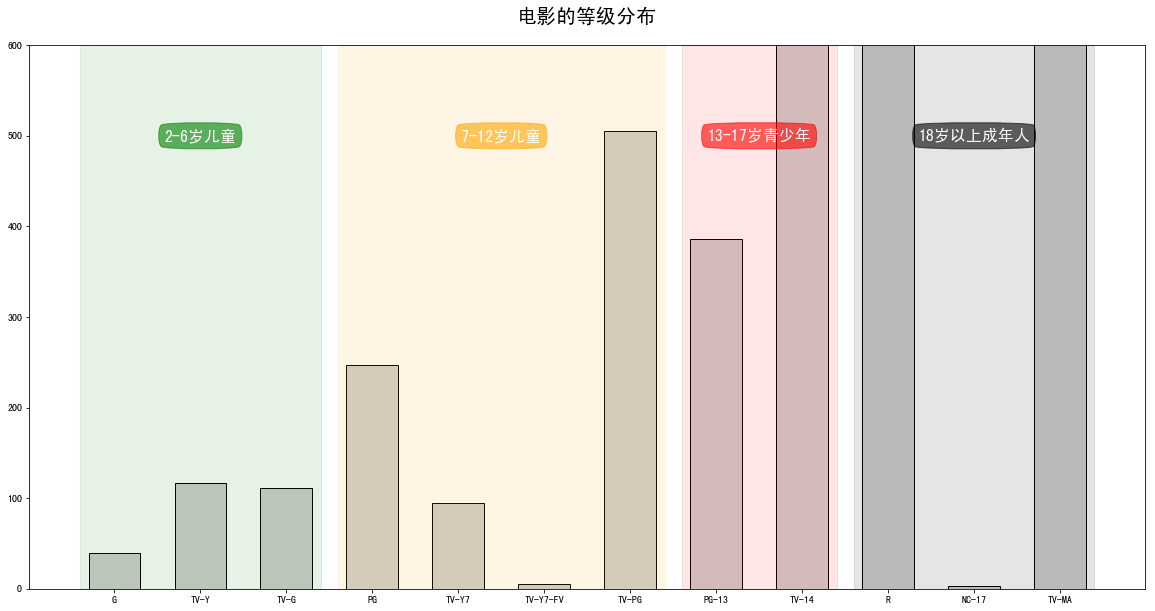

In [30]:
rating_barplot(Movie_rating,'电影', 500, 600)

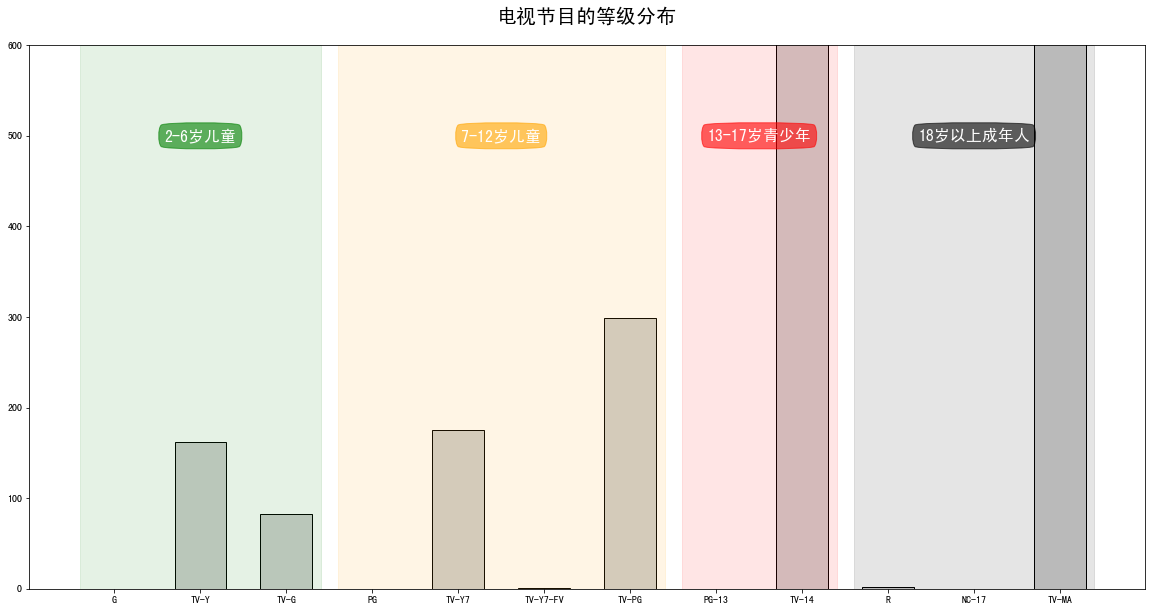

In [31]:
rating_barplot(Tv_rating,'电视节目' , 500, 600)

Netflix上架的电视节目和电影大多数是面向14岁以上青少年和18岁以上的成年人群体。
在2~12岁的儿童群体中，电视节目更受欢迎；可能是随着Netflix的家用电视产品逐渐推出，适合儿童观影的环境提升了。
很显然，不同等级的收视率可以帮助圈定用户群体的大致范围。

### 分析电影和电视节目的播放时长异同

1）电影的时长分布

/Users/weiminpang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/weiminpang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



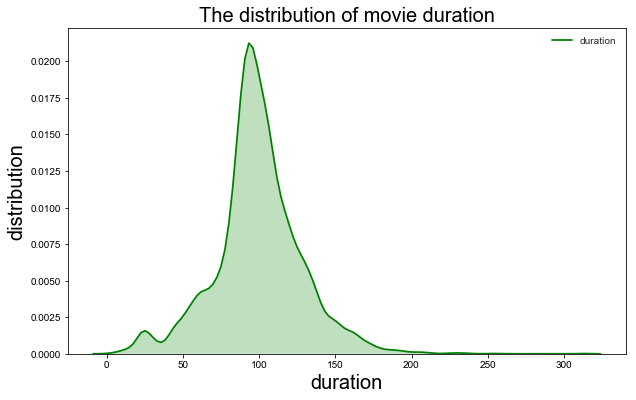

In [32]:
#核密度估计图
plt.subplots(figsize=(10,6))
plt.xlabel('duration',fontsize=20)
plt.ylabel('distribution',fontsize=20)
plt.title('The distribution of movie duration',fontsize=20)
movie_df['duration']=movie_df['duration'].astype(str).str.replace(' min','')
movie_df['duration']=movie_df['duration'].astype(str).astype(int)
sns.set(style="darkgrid")
sns.kdeplot(data=movie_df['duration'], shade=True,color="g")

因此，Netflix上大部分电影都在75-120分钟之间。很多观众不能接受两个半小时以上的电影时长。

2）电视节目的时长

In [33]:
#漏斗图
tv_time=TVshow_df['duration'].value_counts()
data = dict(
    Count=tv_time.values.tolist(),
    Season=tv_time.index.tolist())
fig = px.funnel(data, x='Count', y='Season')
fig.show()

<img src="PlotlyChart/plotly6.png" width="80%">

Netflix中电视节目时长大部分只有1~3季，10季以上的王牌电视节目分别有：

In [34]:
df_11=TVshow_df[TVshow_df['duration'] =='11 Seasons']
df_12=TVshow_df[TVshow_df['duration'] =='12 Seasons']
df_13=TVshow_df[TVshow_df['duration'] =='13 Seasons']
df_15=TVshow_df[TVshow_df['duration'] =='15 Seasons']
df_16=TVshow_df[TVshow_df['duration'] =='16 Seasons']
title_data=[df_11['title'].tolist(),df_12['title'].tolist(),df_13['title'].tolist(),df_15['title'].tolist(),df_16['title'].tolist()]
data={"王牌电视节目":title_data}
pd.DataFrame(data,index=["11 Seasons","12 Seasons","13 Seasons","15 Seasons","16 Seasons"] )

王牌电视节目
11 Seasons                  [Heartland, Cheers]
12 Seasons  [Trailer Park Boys, Criminal Minds]
13 Seasons             [COMEDIANS of the world]
15 Seasons                 [Supernatural, NCIS]
16 Seasons                     [Grey's Anatomy]

季数最高（Top2）的电视节目是《格蕾的解剖》和Supernatural, NCIS。
《格蕾的解剖》是一部美国医学电视剧，2005年3月27日在美国广播公司（ABC）首播，作为一部中期电视剧的替代品。这个虚构的系列关注外科实习生、住院医生和主治医生的生活，因为他们在努力维持个人生活和健康的同时，发展成为经验丰富的医生关系。灰色《解剖》在2019年9月26日首映的第十六季中再次上演。这部电视剧的成功使庞佩奥、邓普西、钱伯斯、卡普肖和Oh等长期演员获得了全球认可；他们是2013年收入最高的五大电视演员之一。

Supernatural---->补充！！
NCIS是一部美国行动警察程序电视连续剧，围绕着一个虚构的海军刑事调查局特工队展开。这个概念和人物最初是在哥伦比亚广播公司（CBS）的两个系列JAG中引入的（第八季第20集和第21集：“冰女王”和“熔毁”）。该剧是JAG的衍生产品，于2003年9月23日在CBS首映。迄今为止，它已经播出了16个完整的赛季，并已进入广播辛迪加在美国网络。Donald P.Bellisario和Don McGill是NCIS特许经营权首映成员的共同创作者和执行制片人。截至2019年，这是目前播出的美国黄金时段第二长的非动画脚本电视连续剧，仅次于《法律与秩序：特别受害者单元》（1999年至今），是美国黄金时段第七长的脚本电视连续剧。

那么，这些多年的王牌电视节目都是什么流派（类型）的呢？

  ### 分别比较电影和电视节目的流派异同

1）电影的流派

In [35]:
#绘制热力图
from sklearn.preprocessing import MultiLabelBinarizer # Similar to One-Hot Encoding

def relation_heatmap(df, title):
    df['genre'] = netflix_data['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print(f"Netflix{title}数据集中的{len(Types)}种流派类型")    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(15, 14))
    pl = sns.heatmap(corr, mask=mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, square=True, linewidths=.7, cbar_kws={"shrink": 0.6})
    
    plt.show()


/Users/weiminpang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Netflix电影数据集中的20种流派类型


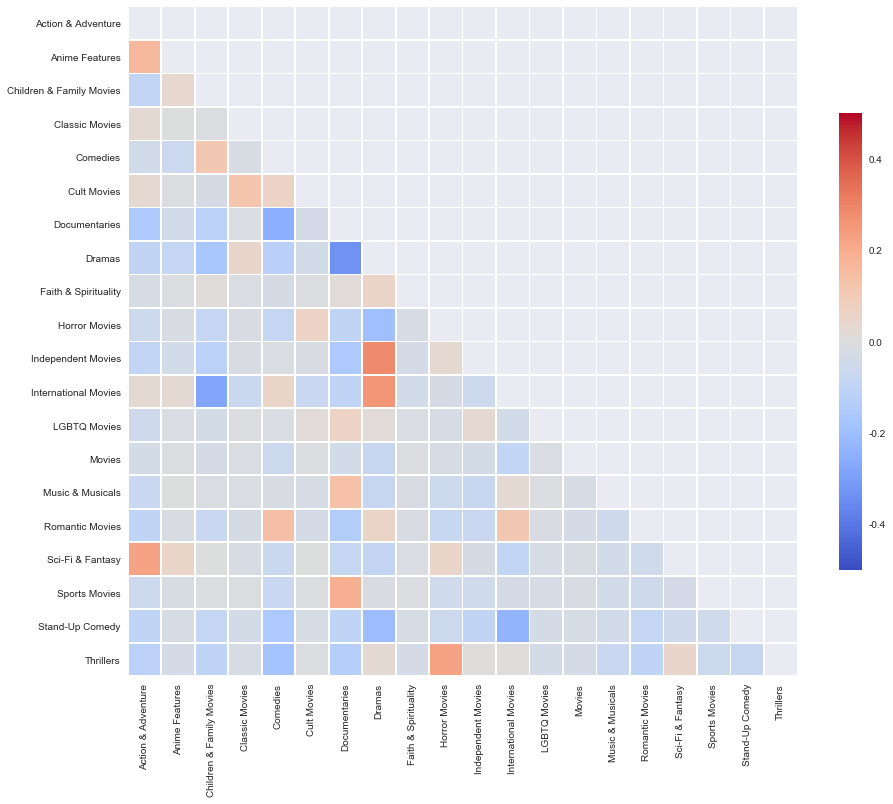

In [36]:
relation_heatmap(movie_df, '电影')

热力图中显示电影不同流派之间的相似性，以下流派（热力图中显示范围为0.2~0.4）相似性较强，故经常作为电影的流派组合：
* 独立制片电影&戏剧
* 国际电影&戏剧
* 科幻&动作冒险
* 恐怖&惊悚

反观，戏剧&纪录片，国际&儿童与家庭的组合流派在电影中最为少见。

In [37]:
movie_df['duration']=movie_df['duration'].astype(str).astype(int)

/Users/weiminpang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



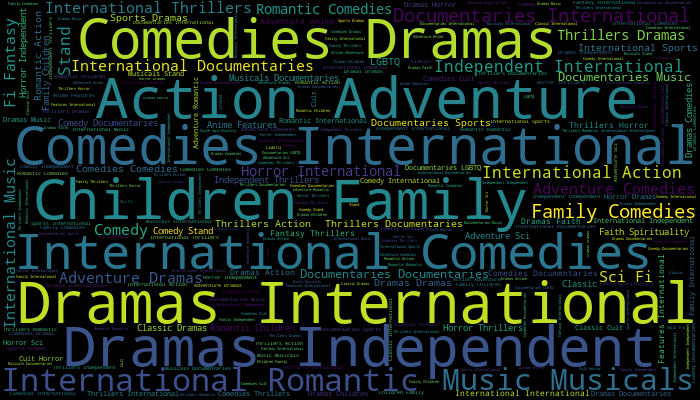

In [38]:
#绘制电影的词云图
from wordcloud import WordCloud
from PIL import Image
wcd=WordCloud(repeat=True,height=400,width=700,
              max_font_size=None)
text = str(movie_df['listed_in'].tolist()).replace("'", '').replace('[', '').replace(']', '')
M=text.replace("Movies", '')
wcd.generate(M)
wcd.to_image()

WordCloud中显示Netflix上的电影常见的流派（关键字从大到小）：
* 戏剧 > 国际电影 > 独立电影 > 喜剧 > 动作冒险 > 儿童&家庭

2）电视节目的流派

/Users/weiminpang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Netflix电视节目数据集中的22种流派类型


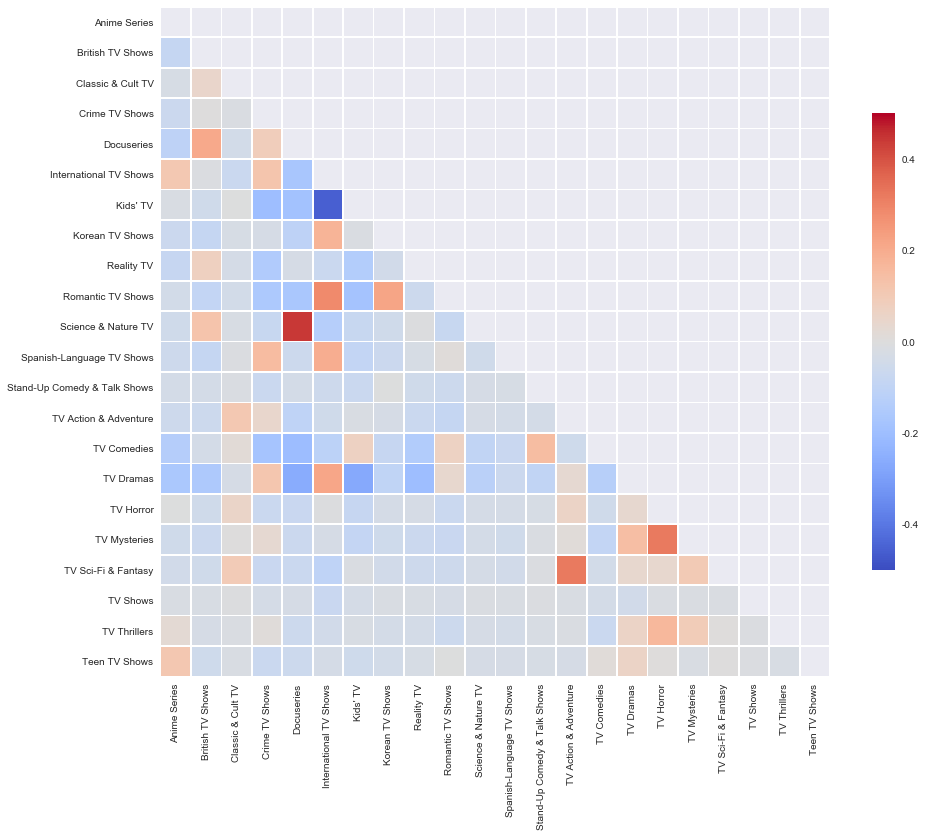

In [39]:
#绘制热力图
relation_heatmap(TVshow_df, '电视节目')

热力图中显示电视节目不同流派之间的相似性，以下流派组合之间的（热力图中显示范围为>0.3）相似性较强：
* 科学自然&纪录片
* 科幻&动作冒险
* 悬疑&惊悚
* 国际&浪漫
与电影相同，电视节目中国际&儿童的流派组合最不相似，最不相关。
显然无论是电影还是电视节目，属于儿童的国际流派是Netflix上很少采用的。

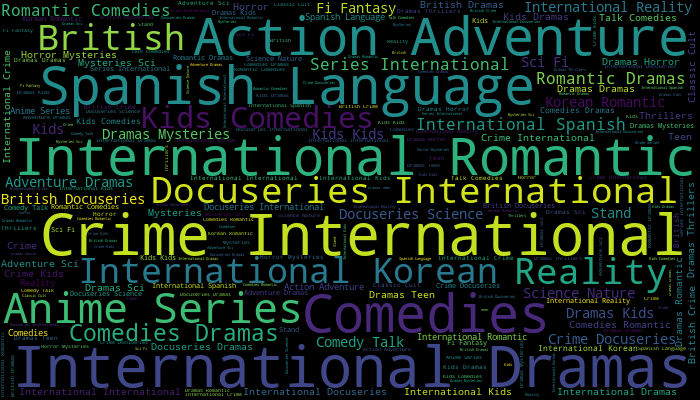

In [40]:
#绘制电视节目的词云图
wcd=WordCloud(repeat=True,height=400,width=700,
              max_font_size=None)
text = str(TVshow_df['listed_in'].tolist()).replace("'", '').replace('"', '').replace('[', '').replace(']', '')
TV=text.replace("TV", '').replace("Shows", '')
wcd.generate(TV)
wcd.to_image()  

WordCloud中显示Netflix上的电视节目常见的流派（关键字从大到小）：
* 国际&戏剧 > 国际&犯罪 > 国际&浪漫 > 喜剧 > 动作冒险 > 西班牙节目 > 纪录片


总结A：通过探索性分析可知，自2016年起，Netflix迅速发展，越来越关注电影的投放，大多产自美国，印度和英国地区；2020年因为新冠疫情，上映量有所增缓，下一阶段的上映建议：
* 关注2021年关键词：医疗，科幻&动作冒险，国际等，电影侧重投资戏剧，国际电影和独立电影等流派；电视侧重投资国际医疗，戏剧和犯罪等流派。
* 上映的电影时长控制在2.5个小时以内，电视节目优先选择投资原先已上映超过3季的节目。
* 上映时间侧重于每年的8~12月，尤其10~12月最佳；1~8月，可优先侧重上映适合2~12岁儿童群体的电视节目以及18岁以上的成年人群体的电影内容。

## 2）分析导演和演员是否因作品受欢迎程度产生影响

### 合并数据集并清洗

通过webscraper插件爬取TMDB上5000条电影和电视节目的评分，联合Netflix的数据集，筛选出数据并分析Top3的国家（美国，印度和英国）电影的导演和演员是否因作品受欢迎程度产生影响。

In [4]:
#读取两个数据集
df_1 = pd.read_csv('dataset/netflix_titles.csv')

df_2 = pd.read_csv('dataset/tmdb_5000_movies.csv')
#合并数据集并筛选出交集
merge_df = pd.merge(df_1, df_2, how = 'inner', on = 'title')
#删除与分析无关的列
merge_df.drop(['budget','homepage','id','keywords','original_language','overview','production_companies',
              'production_countries','date_added_y','revenue','runtime','spoken_languages','status',
              'tagline','title.1'],axis=1,inplace=True)
#处理缺失值和重复值
#删除缺失值
merge_df.dropna(inplace=True)

# 删除重复值
merge_df.drop_duplicates(inplace= True)
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 0 to 617
Data columns (total 16 columns):
show_id         559 non-null object
type            559 non-null object
title           559 non-null object
director        559 non-null object
cast            559 non-null object
country         559 non-null object
date_added_x    559 non-null object
release_year    559 non-null int64
rating          559 non-null object
duration        559 non-null object
listed_in       559 non-null object
description     559 non-null object
genres          559 non-null object
popularity      559 non-null float64
vote_average    559 non-null float64
vote_count      559 non-null int64
dtypes: float64(2), int64(2), object(12)
memory usage: 74.2+ KB


合成并筛选后的新表中一共559行数据，包含15个变量，分别为id号，类型，电影/电视名，导演，演员，国家，上架日期，发行日期，级别，时长，流派，流派id,欢迎程度（在TMDB上的相对页面查看次数），平均评分，评分次数。

In [5]:
#保存数据
merge_df.to_csv('dataset/MergData.csv')
#用Excel处理country列中的多项值后，导入数据
new_data = pd.read_csv('dataset/Merged_Data.csv')

In [43]:
country_data=new_data['country'].value_counts()
country_top20=country_data.head(20)
data = dict(
    Count=country_top20.values.tolist(),
    Country=country_top20.index.tolist())
fig = px.funnel(data, x='Count', y='Country')
fig.show()

<img src="PlotlyChart/plotly7.png" width="80%">

Netflix内容分发数量排名Top2的国家是美国和英国，且美国远超其他国家。

### 在美国和英国，制片数量是否影响导演和演员的受欢迎程度和口碑？

In [44]:
movie_data=new_data[new_data['type']=='Movie']
tv_data=new_data[new_data['type']=='TV Show']
#电视节目的导演
tv_data['country']

1    Taiwan
Name: country, dtype: object

电视节目只有一组台湾地区的数据，单独拆开无分析价值，因此后面的分析无需区分电影和电视节目类型。

1）制片数量排名Top10的导演

In [45]:
#电影数量排名Top10的导演
director=new_data['director'].value_counts()
director_top10=director.head(10)
#柱形图
trace_1=go.Bar(x=director_top10.index.tolist(),y=director_top10.values.tolist(),
               marker=dict(color='red'),opacity=0.5)
layout = dict(height=500, width=800,title = '制片数量TOP10的导演', xaxis = dict(title = '导演'), yaxis = dict(title = '数量'))
fig = dict(data=trace_1, layout=layout)
pyplot(fig)

<img src="PlotlyChart/plotly8.png" width="80%">

<img style="float: left;" src="picture/Steven Spielberg.png" width="50%">

* 1946年12月18日出生于美国俄亥俄州辛辛那提市，美籍犹太裔导演、编剧、制片人。
* 1975年，执导惊悚电影《大白鲨》获得了第33届美国电影电视金球奖电影类-最佳导演提名。
* 1982年，执导科幻家庭电影《外星人E.T.》获得了第40届美国电影电视金球奖电影类-最佳导演提名。
* 1993年，拍摄科幻冒险电影《侏罗纪公园》；同年执导战争电影《辛德勒的名单》获得了第51届美国电影电视金球奖电影类-最佳导演和第66届奥斯卡金像奖 最佳导演奖。
* 1998年，拍摄战争电影《拯救大兵瑞恩》获得第56届美国电影电视金球奖电影类-最佳导演和第71届奥斯卡金像奖最佳导演奖。
* 2002年，执导科幻悬疑电影《少数派报告》获得第29届土星奖最佳导演奖。
* 2005年，拍摄惊悚电影《慕尼黑》获得了第66届美国电影电视金球奖终身成就奖。

2）制片数量排名Top10的演员

In [46]:
cast=new_data['cast'].value_counts()
cast_top10=cast.head(10)
trace_2=go.Bar(x=cast_top10.index.tolist(),y=cast_top10.values.tolist(),
               marker=dict(color='blue'),opacity=0.5)
layout = dict(height=500, width=800,title = '参演作品TOP10的演员', xaxis = dict(title = '演员'), yaxis = dict(title = '数量'))
fig = dict(data=trace_2, layout=layout)
pyplot(fig)

<img src="PlotlyChart/plotly9.png" width="80%">

<img style="float: left;" src="picture/Adam Sandler.png" width="25%">
Adam Sandler(亚当·桑德勒)是著名美国电影演员、电影制作人。参演美国喜剧节目《周六夜现场》之后成为一名杰出的喜剧人，之后晋升为好莱坞的重要演员，并且演出了7部制作预算超过1亿美元的大型电影。
* 1993年，出演的科幻喜剧电影《尖头外星族》上映；同年，发行个人第一张专辑《人们都将嘲笑你》获得格莱美提名，并在百老汇排行榜上停留了100多个星期，售出了500万张。
* 1994年，出演喜剧电影《救命恩人》；同年，主演犯罪音乐电影《摇滚总动员》。
* 1995年，主演喜剧电影《阿呆闯学堂》。
* 2011年，获得第37届美国人民选择奖最受欢迎喜剧明星奖；2月11日，凭借主演的爱情喜剧电影《随波逐流》入围第13届青少年选择奖最佳浪漫喜剧电影男演员奖。
* 2012年6月4日，参与配音的动画电影《精灵旅社》上映，他在片中为吸血鬼之王德库拉伯爵配音，凭借该片获得第39届人民选择奖最受欢迎喜剧片男演员奖。

Netflix上的作品数量与导演/演员的口碑虽不呈明显的正相关关系，但是口碑和自身能力确实影响Netflix的电影上映量。
美国几乎封神的著名导演Steven Spielberg的电影质量和上映数量远高于其他导演，并且往昔代表作与获得的奖项不计其数。
美国著名喜剧演员Adam Sandler在电影喜剧和爱情题材的电影也深受欢迎。

### 3）电影/电视节目的评分与热度（受欢迎程度）是否存在影响？

In [47]:
#受欢迎程度和评分的数据
new_data.sort_values(by='vote_count',inplace=True,ascending=False)
vot_df=new_data['vote_count'].values.tolist()
pop_df=new_data['popularity'].values.tolist()

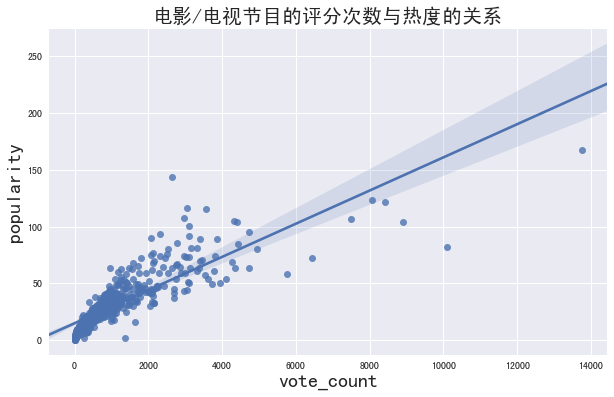

In [48]:
from matplotlib.font_manager import _rebuild
_rebuild()
#设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 散点图
plt.subplots(figsize=(10,6))
plt.xlabel('评分次数',fontsize=20)
plt.ylabel('热度',fontsize=20)
plt.title('电影/电视节目的评分次数与热度的关系',fontsize=20)
sns.regplot(x='vote_count',y='popularity',data=new_data)

In [49]:
#气泡图
colors = np.random.rand(len(vot_df))#set color equal to a variable
sz =pop_df
fig = go.Figure()
fig.add_scatter(x=vot_df,y=pop_df,mode='markers',marker={'size': sz,'color': colors,'opacity': 0.7,'colorscale': 'Viridis','showscale': True})
pyplot(fig)

<img src="PlotlyChart/plotly10.png" width="80%">

可以看出，4000次以内，评分次数和热门程度呈正相关线性关系的，电影/电视节目被评价的次数越高，说明越受欢迎。
导演和演员的口碑影响作品的数量，电影/电视节目的评分次数和热门程度息息相关。由此可见，用户的喜好通常与电影的流派，情节，导演，演员，热门程度有关。那么如何结合用户的喜好匹配精准的内容推荐给用户呢？

# 五.推荐系统（构建推荐引擎）

推荐系统是一种信息过滤系统，因为它们可以提高搜索结果的质量，并提供与搜索项更为相关或与用户的搜索历史相对应的选项。它们用于预测用户对某项商品的评价或偏好。

推荐系统基本上有三种类型：

* 1）受众特征过滤：根据电影的受欢迎程度，它们向每个用户提供通用推荐。系统通过统计向具有相似特征的用户推荐相同的电影。由于每个用户都不相同，因此该方法被认为过于简单。该系统背后的基本思想是，更受大众欢迎和好评的电影具有更高的被普通观众喜欢的可能性。

* 2）基于内容的推荐：根据特定物品推荐相似的物品。该系统使用物品元数据（例如电影的流派，导演，描述，演员等）来提出这些推荐建议。这些推荐系统背后的总体思想是，如果某人喜欢某个特定物品，那么他（她）也将喜欢与之相似的物品。

* 3）协同过滤：该系统找到具有相似兴趣的人或者相似度接近的物品，并根据计算结果提供推荐建议。

<img src="picture/推荐系统.png" width="30%">

In [50]:
#导入数据
df = pd.read_csv('New_Data.csv')

## 1) 基于特征推荐

根据B部分的分析可知，电影/电视的受欢迎程度与评分次数呈正相关关系，那么特征推荐可以根据内容的评分排行（备受好评）来过滤筛选内容。
采用TMDB的评分机制：贝叶斯统计的算法得出的加权分(Weighted Rank-WR)。

<img src="picture/WR.png" width="35%">
其中：
* v 电影的评分人数;
* m 系统要求最低的电影的评分人数;
* R 电影平均评分
* C 所有电影的平均评分

已知v(vote_count) 和 R (vote_average) ，可以计算C

In [51]:
#计算C
C= df['vote_average'].mean()
#计算m，预估内容的评分人数超过列表中至少90％的电影
m= df['vote_count'].quantile(0.9)
#筛选出符合条件的电影
q_movies = df.copy().loc[df['vote_count'] >= m]
q_movies.shape

(56, 48)

有56部电影符合条件，接下来，计算每个合格电影的分数。

In [52]:
#定义一个函数weighted_rating（）
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
#增加一个新特征score
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
#计算电影分数并且排序
q_movies = q_movies.sort_values('score', ascending=False)
#输出加权后评分前10名电影
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

title  vote_count  vote_average  \
507                                   Pulp Fiction        8428           8.3   
199                                      Inception       13752           8.1   
401  The Lord of the Rings: The Return of the King        8064           8.1   
421          The Lord of the Rings: The Two Towers        7487           8.0   
513                               Schindler's List        4329           8.3   
463                                     The Matrix        8907           7.9   
134                               Django Unchained       10099           7.8   
241                           Inglourious Basterds        6430           7.9   
522                                     GoodFellas        3128           8.2   
468                             American History X        3016           8.2   

        score  
507  7.839286  
199  7.821039  
401  7.671618  
421  7.572448  
513  7.564966  
463  7.547708  
134  7.501086  
241  7.450590  
522  7.354596  
468  7.337601

最基本的推荐引擎构建完成，可以通过按“受欢迎度”列对数据集进行排序来推荐电影。但并不是每个用户的喜好都是按照评分来排序的，可能因为不同流派和情节的偏好，喜好自然也不同。

## 2) 基于内容推荐

### 单一过滤元素（基于"情节描述"进行内容过滤）
TF-IDF（术语频率-反文档频率（TF-IDF））分数是文档中出现的单词的频率，并根据出现该单词的文档数量进行加权。这样做是为了降低在情节概述中经常出现的单词的重要性，从而降低其在计算最终相似度得分中的重要性。

In [53]:
rec_df = df[['title','director','cast','listed_in','description']]
from sklearn.feature_extraction.text import TfidfVectorizer
#将空格代替缺失值NAN
rec_df['description'] = rec_df['description'].fillna('')
TFIDF = TfidfVectorizer(stop_words='english')
#将数据转化为矩阵的形式
TFIDF_matrix = TFIDF.fit_transform(rec_df['description'])
#输出TF-IDF矩阵的形态
TFIDF_matrix.shape

/Users/weiminpang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(559, 3937)

数据集中一共有3937个词来形容559部电影/电视节目。

余弦相似度（Cosine Similarity）
* 余弦相似度，又称为余弦相似性，是通过计算两个向量的夹角余弦值来评估他们的相似度。
* 余弦相似度衡量的是2个向量间的夹角大小，通过夹角的余弦值表示结果，余弦值越大，相似度越大，反之相似度越小。
* 因此可使用余弦相似度算法计算两部电影/电视节目情节矩阵的相似度，相速度越大推荐的可能性越强。

<img src="picture/Cosine Similarity.png" width="60%">

In [54]:
from sklearn.metrics.pairwise import linear_kernel
#计算余弦相似度的值
cosine_sim1 = linear_kernel(TFIDF_matrix, TFIDF_matrix)
#根据标题获得电影的索引
indices = pd.Series(rec_df.index, index=rec_df['title']).drop_duplicates()

#构建推荐引擎
def get_recommendations(title, cosine_sim=cosine_sim1):
    #获取与标题匹配的电影的索引
    idx = indices[title]
    #获取该电影与所有电影的相似度分数列表
    sim_scores = list(enumerate(cosine_sim1[idx]))
    #根据相似度得分对电影进行排序
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # 获取排名前10最相似的电影分数，第一部电影忽略，最相似的是指定电影本身
    sim_scores = sim_scores[1:11]
    # 获取电影索引
    names_indices = [i[0] for i in sim_scores]

    # 返回前10个最相似的电影
    return rec_df['title'].iloc[names_indices]

In [55]:
get_recommendations('Room',cosine_sim1)

418    Raising Victor Vargas
312            Into the Wild
424      Along Came a Spider
147        Playing for Keeps
288       Revolutionary Road
13               Point Blank
497              Sling Blade
367           V for Vendetta
545              Taxi Driver
52         Jupiter Ascending
Name: title, dtype: object

In [56]:
get_recommendations('Lincoln',cosine_sim1)

61         The Hateful Eight
139              John Carter
28       Free State of Jones
532                  Platoon
369     Yours, Mine and Ours
362    The Amityville Horror
93         The Water Diviner
345           The Lake House
536            The Evil Dead
4                   The Call
Name: title, dtype: object

该模型表现良好，但仅基于具有类似情节描述的电影推荐并不具有较高的精准度，比如《房间》这部电影属于心理&惊悚片，推荐模型会推荐所有类似情节的电影，但用户可能只喜欢《房间》女主布丽·拉尔森（Brie Larson）参演的作品，这一点推荐模型还无法满足，因此可以向该模型添加更多指标以提高推荐性能。


### 多种过滤元素（基于"导演"，"演员"，"流派"和"情节关键词"进行内容过滤）

清洗数据

In [57]:
#用空字符串填充空值
filled_df=rec_df.fillna('')
#筛选用于内容过滤的特征
feature=['title','director','cast','listed_in','description']
filled_df=filled_df[feature]
#将所有大写字母转换成小写字母
def clean_data(x):
        return str.lower(x.replace(" ", ""))
    
for F in feature:
    filled_df[F] = filled_df[F].apply(clean_data)

构建多种过滤特征的推荐引擎

In [58]:
#创建一个soup,将所有特征行放入其中
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

filled_df['soup'] = filled_df.apply(create_soup, axis=1)

In [59]:
#将数据转化为向量矩阵的形式
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
count = CountVectorizer(stop_words='english')
feature_matrix = count.fit_transform(filled_df['soup'])
cosine_sim2 = cosine_similarity(feature_matrix, feature_matrix)

#重置DataFrame的索引
filled_df=filled_df.reset_index()
indices = pd.Series(filled_df.index, index=filled_df['title'])

#构建推荐引擎
def get_recommendations_new(title, cosine_sim=cosine_sim2):
    title=title.replace(' ','').lower()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim2[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return rec_df['title'].iloc[movie_indices]

In [60]:
get_recommendations_new('Room', cosine_sim2)

459                 Magnolia
126      The Spectacular Now
42     Two Lovers and a Bear
12                       Joy
8                    Brother
106               Concussion
335         Loving Annabelle
0                      Cargo
37           Ordinary People
28       Free State of Jones
Name: title, dtype: object

In [61]:
get_recommendations_new('Lincoln', cosine_sim2)

324    There Will Be Blood
412      Gangs of New York
157                  50/50
69     A Most Violent Year
312          Into the Wild
409    Catch Me If You Can
224          Winter's Bone
79      Kill the Messenger
131            Big Miracle
282                   Milk
Name: title, dtype: object

基于更多指标（"导演"，"演员"，"流派"和"情节关键词"）进行过滤后，观看《房间》电影的用户可以被推荐到同演员（女主布丽·拉尔森（Brie Larson））参演的电影，如浪漫喜剧：《The Spectacular Now》。